Before loading the images, i must check the dataset for any class imbalances to identify if certain classes are underrepresented or not. If they are, then the model might predict towards more frequently seen classes which would lead to lower accuracy. I will count the number of images in each directory and then visualize this information on a graph.

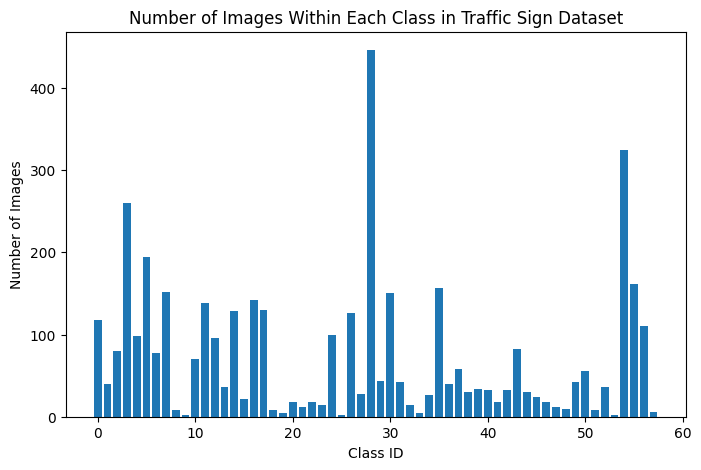

In [8]:
import os

from matplotlib import pyplot as plt

data_path = 'data/traffic_Data/DATA' 

# Dictionary storing classes and the amount of images in each class
class_image_counts = {}
for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    class_image_counts[class_id] = len(os.listdir(directory))
    
# Plotting the data for each class
plt.figure(figsize=(8, 5))
plt.bar(class_image_counts.keys(), class_image_counts.values())
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Number of Images Within Each Class in Traffic Sign Dataset')
plt.show()

As seen above, the classes have a very uneven distribution, which is will have a negative effect on the output and results of the model. To try and mitigate the problem, I have firstly set the class weights hyperparameter to be "balanced" within the SVM classifier model, which will make it pay more attention to underrepresented classes by treating their misclassifications as more significant than other classes.

Before loading in the images, I want to verify that each image (in both the test set and data set) is a valid input to the SVM classifier model and is readable.
I will use Pillow (PIL) to handle the images.

In [9]:
import os
from PIL import Image

test_path = 'data/traffic_Data/TEST'
labels_path = 'data/labels.csv'

# Verifying the images in the DATA set

valid_images = []
for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        for img_file in os.listdir(directory):
            try:
                image = Image.open(os.path.join(directory, img_file))
                image.verify()
                valid_images.append(os.path.join(directory, img_file))
            except Exception as e:
                print(f"Image not valid: {img_file}, Error: {e}")

# Verifying the images in the TEST set

valid_images = []
for class_id in range(58):
    directory = os.path.join(test_path, str(class_id))
    if os.path.exists(directory):
        for img_file in os.listdir(directory):
            try:
                image = Image.open(os.path.join(directory, img_file))
                image.verify()
                valid_images.append(os.path.join(directory, img_file))
            except Exception as e:
                print(f"Image not valid: {img_file}, Error: {e}")

print("All images successfully verified.")
                

All images successfully verified.


The images must be loaded from the directories, and then pre-processed so they can be fed into the SVM classifier.
I will pre-process each image and load it in with it's corresponding ClassId.
The labels for the dataset are loaded in as a dataframe from the csv file.

I have chosen to combine the DATA and TEST sets and do the pre-processing steps together for both, as I found that there were issues with the model generalizing to the TEST file after training on the DATA file.

I have also chosen to resize each image to 32x32 and turn it into greyscale to process less features, this reduces memory usage and speeds up training (and still leaves enough features for the model to effectivley distinguish classes). The images are flattened aswell as the SVM model expects a 2D array as input.

In [10]:
import os
import cv2
import numpy as np
import pandas as pd

images = []
class_ids = []
labels = pd.read_csv(labels_path)

for class_id in range(58):
    data_directory = os.path.join(data_path, str(class_id))
    test_directory = os.path.join(test_path, str(class_id))
    
    if os.path.exists(data_directory):
        for img_file in os.listdir(data_directory):
                img_path = os.path.join(data_directory, img_file)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (32, 32)) # Resize
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Greyscale
                image = image.flatten() # Flatten
                images.append(image)
                class_ids.append(class_id)
    
    if os.path.exists(test_directory):
        for img_file in os.listdir(test_directory):
            img_path = os.path.join(test_directory, img_file)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (32, 32)) # Resize
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Greyscale
            image = image.flatten() # Flatten
            images.append(image)
            class_ids.append(class_id)
    
# Define X (input data) and y (target data) as numpy arrays
X = np.array(images) / 255.0
y = np.array(class_ids)

print(f"Total images loaded: {len(images)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Total images loaded: 6164
Shape of X: (6164, 1024)
Shape of y: (6164,)


Next, before splitting the data I will carry out 2 more steps.
Firstly, we standardize (scale) the features so the transformation is applied uniformly across the whole dataset. If this was done after splitting, then there is a risk of different scaling parameters (e.g mean and variance) across the training and testing sets.
Secondly, we apply Principle Component Analysis (PCA) to extract the most meaningful features by keeping the principle components that capture the most variance. This makes the SVM model even faster to train and more computationally efficient without a significant loss in accuracy.

I have used the method outlined in the PCA tutorial to plot cumulative variance against the number of components, to visualise and determine the minimum amount of principle components to use.
It seems like 250 components capture around 95% of the variance, which is sufficient.

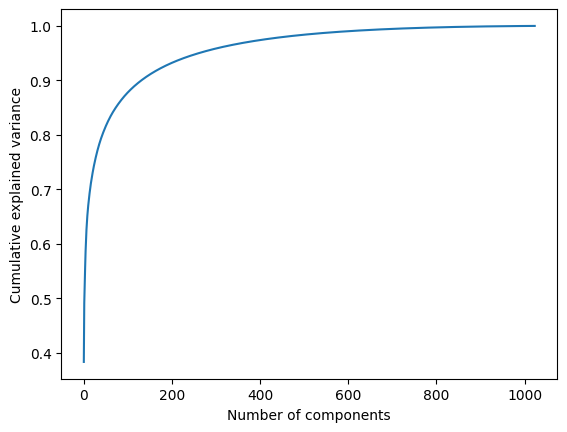

In [11]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_test = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

pca = PCA(n_components=250)
X_pca = pca.fit_transform(X_scaled)

Now the input is ready, the dataset can be split into training, validation and test sets. 
The validation set will be used for tuning the model, and the test set will be used to predict.
I firstly partitioned the dataset into "training" and "temp", and then split the "temp" into "val" and "test" sets.

Then we fit the SVM classifier model with the data and define kernel type, along with the C value.
The kernal type specifies the type of function used to transform the input data to a higher dimensional space.
The C value controls the trade-off between maximizing the margin and minimizing the classification error.
- High C value = model will aim to classify as many points correctly as possible, penalizing misclassifications heavily (risk of overfitting)
- Low C value = model allows more misclassifications to maintain a larger margin (focusing more on general patterns, risk of underfitting)

Then we can meassure the model accuracy both on the training and validation sets.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

svc = SVC(class_weight="balanced", kernel="linear", C=0.1)
svc.fit(X_train, y_train)

train_acc = svc.score(X_train, y_train)
val_acc = svc.score(X_val, y_val)
print(f"Training Accuracy: {train_acc:.3g}")
print(f"Validation Accuracy: {val_acc:.3g}")

Shape of X_train: (4314, 250)
Shape of X_val: (925, 250)
Shape of X_test: (925, 250)
Training Accuracy: 0.999
Validation Accuracy: 0.945


Then we can test the model on the partitioned testing set to see how well the results are generalized to new data.

In [13]:

import os
from sklearn.metrics import accuracy_score

y_pred = svc.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.94


The model achieves an accuracy of 94%, which means it generalizes very well to new data and can be used to classify different traffic signs from the dataset.